# Прогнозирование стоимости автомобиля по его характеристикам

### Задачи:  
1. Спарсить данные по автомобилям с сайта auto.ru  
2. Подобрать и обучить модель по собранным данным для прогнозирования стоимости авто. Метрика MAPE.



# 1. Tools

In [10]:
import numpy as np
import pandas as pd
import sys
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.base import clone
import datetime as dt
from sklearn.feature_selection import f_classif #проверить значимость переменных
from itertools import combinations 
from scipy.stats import ttest_ind #тест Стьюдента

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import ast

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

RANDOM_SEED = 42

# 2. Data preparation

In [11]:
DATA_DIR = '../input/sf-dst-car-price-prediction/'
df_train = pd.read_csv('../input/myparsingfile/parsing_all_moscow_auto_ru_25_11_20.csv') #спарсил сам
df_train_dop = pd.read_csv('../input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv') # дополнительный внешний
df_test = pd.read_csv(DATA_DIR+'test.csv') #тестовый для прогнозирования цен
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Всего 34686 записей и 32 признака

In [13]:
df_test.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66584 entries, 0 to 66583
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              66581 non-null  object 
 1   brand                 66582 non-null  object 
 2   color                 66582 non-null  object 
 3   fuelType              66581 non-null  object 
 4   image                 66581 non-null  object 
 5   modelDate             66581 non-null  float64
 6   name                  66582 non-null  object 
 7   numberOfDoors         66581 non-null  float64
 8   productionDate        66582 non-null  float64
 9   vehicleConfiguration  66581 non-null  object 
 10  vehicleTransmission   66581 non-null  object 
 11  priceCurrency         66582 non-null  object 
 12  engineDisplacement    66582 non-null  object 
 13  enginePower           66582 non-null  object 
 14  description           66581 non-null  object 
 15  car_url            

37 признаков

Всего 66584 записей и 37 признаков

In [15]:
df_train.head(3)

,bodyType,brand,color,fuelType,image,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,...,complectation_dict,equipment_dict,equipment_groups,super_gen,vendor,model_info,plus_minus,damages,price_info,price
0,седан,AUDI,чёрный,бензин,https://autoru.naydex.net/1dJf7U276/c2f0f2dGK_...,1991.0,2.3 MT (133 л.с.),4.0,1991.0,SEDAN MECHANICAL 2.3,...,{'id': '0'},{},NaN,"{'id': '7878108', 'name': 'V (B4)', 'ru_name':...",EUROPEAN,"{'code': '80', 'name': '80', 'ru_name': '80', ...","{'positive': [{'name': 'Качество сборки', 'plu...",NaN,"{'price': 165000, 'currency': 'RUR', 'EUR': 18...",165000.0
1,седан,AUDI,синий,бензин,https://autoru.naydex.net/1dJf7U276/c2f0f2dGK_...,1986.0,1.8 MT (90 л.с.),4.0,1991.0,SEDAN MECHANICAL 1.8,...,{'id': '0'},"{'driver-seat-updown': True, 'tinted-glass': T...","[{'name': 'Салон', 'values': ['Регулировка сид...","{'id': '7892649', 'name': 'IV (B3)', 'ru_name'...",EUROPEAN,"{'code': '80', 'name': '80', 'ru_name': '80', ...","{'positive': [{'name': 'Надежность', 'plus_cou...",NaN,"{'price': 155000, 'currency': 'RUR', 'EUR': 17...",155000.0
2,седан,AUDI,зелёный,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,1986.0,2.0 AT (112 л.с.),4.0,1991.0,SEDAN AUTOMATIC 2.0,...,{'id': '0'},{},NaN,"{'id': '7892649', 'name': 'IV (B3)', 'ru_name'...",EUROPEAN,"{'code': '80', 'name': '80', 'ru_name': '80', ...","{'positive': [{'name': 'Надежность', 'plus_cou...",NaN,"{'price': 75000, 'currency': 'RUR', 'EUR': 834...",75000.0


In [16]:
df_train_dop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

Всего 89378 записей и 26 признаков

In [17]:
df_train_dop.head(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100


Необходимо:
1. привести признаки color,vehicleTransmission,Руль к одним значениям  
2. склеить df_train и df_train_dop, а также привести количество признаков полученного датасета data к количеству признаков df_test. 
3. привести строковые признаки к нижнему регистру 
4. удалить строки,где bodyType и price is None
5. отобрать строки в data по значениям brand в df_test (уменьшить итоговый датасет train и увеличить точность модели)

In [18]:
df_train_temp = df_train[df_test.columns]
df_train_temp['price'] = df_train['price']
df_train = df_train_temp

df_train_dop['model_name'] = df_train_dop['model']
df_train_dop['complectation_dict'] = df_train_dop['Комплектация']
df_train_dop.drop(['Комплектация', 'start_date', 'hidden', 'model'],axis=1,inplace= True)

df_train_dop['color'] = df_train_dop['color'].map({'CACECB': 'серебристый', 'FAFBFB':'белый', 'EE1D19':'красный', '97948F':'серый', 
                                     '660099':'пурпурный', '040001':'чёрный','4A2197':'фиолетовый', 
                                     '200204':'коричневый','0000CC':'синий', '007F00':'зелёный', 'C49648':'бежевый',
                                     '22A0F8':'голубой','DEA522':'золотистый','FFD600': 'жёлтый', 'FF8649':'оранжевый',
                                     'FFC0CB':'розовый'})

df_train_dop['vehicleTransmission'] = df_train_dop['vehicleTransmission'].map({'AUTOMATIC': 'автоматическая', 'MECHANICAL':'механическая','VARIATOR': 'вариатор','ROBOT': 'роботизированная'})
df_train_dop['Руль'] = df_train_dop['Руль'].map({'LEFT': 'левый', 'RIGHT':'правый'})

for col in df_train.columns:
    if col not in df_train_dop.columns:
        df_train_dop[col] = None
        
df_train = df_train.append(df_train_dop, sort=False).reset_index(drop=True)

#для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['price'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

data = data[~data.price.isnull()] #убираем строки None для price
data = data[~data.bodyType.isnull()]#убираем лишние строки

#привести все не числовые колонки к нижнем регистру(
for col in data.select_dtypes(include='object').columns:
    data[col][~data[col].isnull()] = data[col][~data[col].isnull()].apply(lambda x: str(x).lower())

#фильтр по брендам
brands = list(map(lambda x: str.lower(x),df_test.brand.value_counts().index))
data = data[data['brand'].isin(brands)]

# 3. Data cleaning, feature analysis and engineering

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122370 entries, 0 to 189930
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              122370 non-null  object 
 1   brand                 122370 non-null  object 
 2   car_url               73270 non-null   object 
 3   color                 122370 non-null  object 
 4   complectation_dict    94073 non-null   object 
 5   description           120791 non-null  object 
 6   engineDisplacement    122370 non-null  object 
 7   enginePower           122370 non-null  object 
 8   equipment_dict        63274 non-null   object 
 9   fuelType              122370 non-null  object 
 10  image                 73269 non-null   object 
 11  mileage               122370 non-null  float64
 12  modelDate             122370 non-null  float64
 13  model_info            73270 non-null   object 
 14  model_name            122370 non-null  object 
 15  

In [20]:
data.select_dtypes(include =['float64']).columns

Index(['mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'price'], dtype='object')

In [21]:
for col in data:
    if len(data[data[col].isnull()]) > 0:
        print(col,end=',')

car_url,complectation_dict,description,equipment_dict,image,model_info,parsing_unixtime,priceCurrency,sell_id,super_gen,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,

34 колонки , 122370 записей , пропуски в колонках  car_url,complectation_dict,description,equipment_dict,image,model_info,parsing_unixtime,priceCurrency,sell_id,super_gen,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня

Числовые признаки:  'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'price'.

### Описание признаков:

bodyType - тип кузова       
brand - бренд      
car_url - ссылка на авто     
color - цвет авто   
complectation_dict - описание комплектации    
description - описание от продавца       
engineDisplacement - объем двигателя в литрах  
enginePower - мощность двигателя  
equipment_dict - описание оборудования авто  
fuelType - тип топлива   
image - ссылка на фото авто   
mileage - пробег автомобиля    
modelDate - дата выпуска модели  
model_info - информация об авто  
model_name - модель авто  
name - объем и мощность двигателя    
numberOfDoors - кол-во дверей    
parsing_unixtime - дата парсинга данных     
priceCurrency - валюта продажи  
productionDate - дата производства авто  
sell_id - id объвления о продаже    
super_gen - доп описание авто (клиренс,расход топлива, ценовой сегмент)  
vehicleConfiguration - комбинация типа трансмиссии, объема двигателя и мощности двигателя    
vehicleTransmission - тип трансмиссии (коробки передач)  
vendor - продавец-производитель авто  
Владельцы - кол-во владельцев  
Владение - срок владения автомобилем в годах и месяцах     
ПТС - тип ПТС    
Привод - привод авто     
Руль - руль авто    
Состояние - необходимость проведения ремонта  
Таможня - информация о том расстаможен автомобиль или нет   
sample - признак train/test    
price - цена, указанная в объявлении   


Скопируем датасет, чтобы при необходимости можно было посмотреть данные исходного датасета.

Создадим два списка для обработки категориальных признаков: разбивка на dummy и LabelEncoder

In [22]:
data_temp = data.copy()

col_dum = []
col_en = []

### Функции

In [23]:
# Показать график по value_counts (если значений не более 20. Иначе выводить обычный value_counts)
def show(col,vc_show = False,data_x = data_temp):
    vc = data_x[col].value_counts(ascending=True)
    if len(vc) <= 20:
        vc.plot(kind='barh', title=col)
    else:
        print(data_x[col].value_counts())
    
    if vc_show and len(vc) <= 20:
        print(data_x[col].value_counts())
    
# Показать распределение на графике для числовых признаков
def show_distplot(col,data_x = data_temp):
    plt.figure()
    sns.distplot(data_x[col][data_x[col] > 0], kde = False, rug=False)
    plt.title(col)
    plt.show()
    
#логарифмировать признак
def log_f(col,data_x = data_temp):
    data_x[col] = np.log(data_x[col] + 1)
    
# Проверка на выбросы
def show_outliers(column,data_x = data_temp):
    col = data_x[column]
    IQR = col.quantile(0.75) - col.quantile(0.25)
    perc25 = col.quantile(0.25)
    perc75 = col.quantile(0.75)

    quan_low_outliers = len(data_x.query(f'{column} < {perc25 - 1.5*IQR}'))
    quan_high_outliers = len(data_x.query(f'{column} > {perc75 + 1.5*IQR}'))

    proc_low_outliers = round(quan_low_outliers/len(col) * 100,2) 
    proc_high_outliers = round(quan_high_outliers/len(col) * 100,2)

    print('Колонка',column)
    print(f'Количество выбросов ниже нижней границы: {quan_low_outliers} ({proc_low_outliers}%)')
    print(f'Количество выбросов выше верхней границы: {quan_high_outliers} ({proc_high_outliers}%)')
    print('\n')

#привести строку к формату ast или json 
def to_dict(row):
    try:
        row = ast.literal_eval(row)
        return row 
    except: 
        try:
            row = json.loads(row)
            return row
        except:
            return row

#получить значение (ast или json)
def get_val(row, val_name, val_er):
    try:
        return row[val_name]
    except:
        return val_er

### body_type

In [24]:
show("bodyType")

внедорожник 5 дв.     49239
седан                 42484
лифтбек                7318
хэтчбек 5 дв.          5984
универсал 5 дв.        3787
                      ...  
седан latio               1
хэтчбек 5 дв. runx        1
минивэн emina             1
седан t140                1
минивэн regius            1
Name: bodyType, Length: 102, dtype: int64


Больше всего продается внедорожников и седанов.

Признак состоит из названия типа кузова и количества дверей. Количество дверей есть в другом признаке. Оставим только первую часть для группировки значений

In [25]:
data_temp['bodyType'] = data_temp['bodyType'].apply(lambda x: str(x).split(' ')[0])

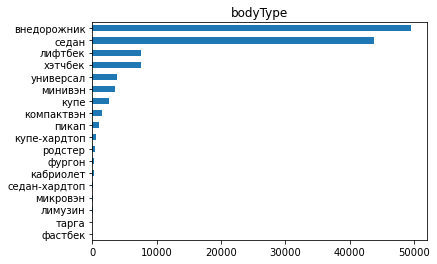

In [26]:
show("bodyType")

Склеим похожие значения.

Добавим признак в dummy ,т.к. значений не так много.

In [27]:
data_temp['bodyType'] = data_temp['bodyType'].apply(lambda x: 'купе' if x == 'купе-хардтоп' else x)
data_temp['bodyType'] = data_temp['bodyType'].apply(lambda x: 'седан' if x == 'седан-хардтоп' else x)

col_dum.append('bodyType')

### brand

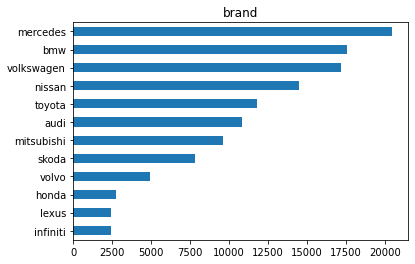

In [28]:
show("brand")

На рынке доминируют мерседесы.

Добавим признак в dummy ,т.к. значений не так много.

In [29]:
col_dum.append('brand')

### car_url

In [30]:
show("car_url")

https://auto.ru/cars/used/sale/nissan/primera/1096980434-8ed9e285/         3
https://auto.ru/cars/used/sale/mercedes/cls_klasse/1101248786-b20ce57b/    3
https://auto.ru/cars/used/sale/volvo/s40/1100730210-7e809d73/              3
https://auto.ru/cars/used/sale/infiniti/fx/1095042584-b1ca0d55/            3
https://auto.ru/cars/used/sale/skoda/kodiaq/1101307736-3cd1d435/           3
                                                                          ..
https://auto.ru/cars/used/sale/toyota/land_cruiser/1082748992-c83bc6/      1
https://auto.ru/cars/used/sale/audi/a4/1099147230-6cb2ccf1/                1
https://auto.ru/cars/used/sale/honda/accord/1096490996-730dd728/           1
https://auto.ru/cars/used/sale/mitsubishi/carisma/1101301485-fec0965d/     1
https://auto.ru/cars/used/sale/bmw/x6/1093207766-764ba56e/                 1
Name: car_url, Length: 60395, dtype: int64


Вряд ли ссылки на авто на сайте auto.ru повлияют на обучение модели. Удалим признак.

In [31]:
data_temp.drop('car_url',axis=1,inplace = True)

### color

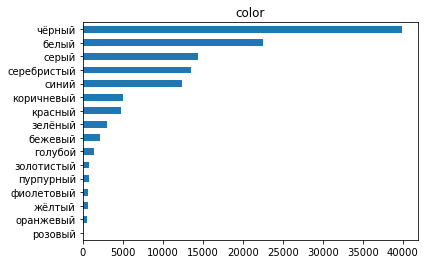

In [32]:
 show("color")

Больше всего машин с черным цветом.Розовый не в почёте.

Добавим признак в dummy ,т.к. значений не так много.

In [33]:
col_dum.append('color')

### complectation_dict

In [34]:
show("complectation_dict")

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Заменим пропуски на минимальный размер описания комплектации

In [35]:
data_temp['complectation_dict'].fillna("{'id': '0'}",inplace = True)

Попробуем привести описание комплектации к его размеру. Проверим на значении метрики

In [36]:
data_temp['complectation_dict'] = data_temp['complectation_dict'].apply(lambda x: len(x))

### description

In [37]:
show("description")

рольф - официальный дилер и лучший дилер россии по итогам продаж и обслуживания автомобилей. мы гарантируем вам самые лучшие условия покупки!\n\nвсе автомобили прошли:\n\n∙ криминалистическую и юридическую проверку.\n∙ комплексную диагностику, вы получаете лист с официальным заключением о состоянии автомобиля.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Заменим пропуски на пустую строку

In [38]:
data_temp['description'].fillna('[]',inplace = True)

Выведем новые признаки

In [39]:
data_temp['description_word'] = data_temp['description'].apply(lambda x: [i for i in x.split()])

data_temp['salon'] = data_temp['description_word'].apply(lambda x: 
                                            1 if ('рольф' or 'панавто' or 'дилер' or 'кредит' or 'обмен' or 'скид' or 'trade-in' or 'выгода' or 'работаем для вас' or 'автосалон' or 'ликвидация') in x else 0)
data_temp['torg'] = data_temp['description_word'].apply(lambda x: 
                                            1 if ('торг') in x else 0)
data_temp['leather']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('темный' and 'салон') in x else 0)
data_temp['carter']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('защита' and 'картера') in x else 0)
data_temp['ABS']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('антиблокировочная' and 'система') in x else 0)
data_temp['airbags']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('подушки' and 'безопасности') in x else 0)
data_temp['immob']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('иммобилайзер') in x else 0)
data_temp['central_locking']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('центральный' and 'замок') in x else 0)
data_temp['on_board_computer']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('бортовой' and 'компьютер') in x else 0)
data_temp['cruise_control']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('круиз-контроль') in x else 0)
data_temp['climat_control']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('климат-контроль') in x else 0)
data_temp['multi_rudder']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('мультифункциональный' and 'руль') in x else 0)
data_temp['power_steering']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('гидроусилитель' or 'гидро' or 'усилитель' and 'руля') in x else 0)
data_temp['light_and_rain_sensors']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('датчики' and 'света' and 'дождя') in x else 0)
data_temp['сarbon_body_kits']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('карбоновые' and 'обвесы') in x else 0)
data_temp['rear_diffuser_rkp']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('задний' and 'диффузор') in x else 0)
data_temp['door_closers']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('доводчики' and 'дверей') in x else 0)
data_temp['rear_view_camera']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('камера' or 'видеокамера' and 'заднего' and 'вида') in x else 0)
data_temp['amg']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('amg') in x else 0)
data_temp['bi_xenon_headlights']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('биксеноновые' and 'фары') in x else 0)
data_temp['alloy_wheels']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('легкосплавные' or 'колесные' or 'диски') in x else 0)
data_temp['parking_sensors']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('парктроник' or 'парктронник') in x else 0)
data_temp['dents']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина') in x else 0)
data_temp['roof_with_panoramic_view']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('панорамная' and 'крыша') in x else 0)

data_temp.drop(['description','description_word'],axis = 1, inplace = True)

In [40]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122370 entries, 0 to 189930
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bodyType                  122370 non-null  object 
 1   brand                     122370 non-null  object 
 2   color                     122370 non-null  object 
 3   complectation_dict        122370 non-null  int64  
 4   engineDisplacement        122370 non-null  object 
 5   enginePower               122370 non-null  object 
 6   equipment_dict            63274 non-null   object 
 7   fuelType                  122370 non-null  object 
 8   image                     73269 non-null   object 
 9   mileage                   122370 non-null  float64
 10  modelDate                 122370 non-null  float64
 11  model_info                73270 non-null   object 
 12  model_name                122370 non-null  object 
 13  name                      122370 non-null  o

### engineDisplacement

In [41]:
show("engineDisplacement")

2.0 ltr    18691
1.6 ltr    10246
3.0 ltr     8789
2.0         7031
1.8 ltr     5915
           ...  
218d           1
xc             1
535li          1
4.8            1
sf             1
Name: engineDisplacement, Length: 465, dtype: int64


Заменим "ltr" на "". Тогда признак получится преобразовать в числовой

In [42]:
def change_ltr(row):
    row_temp = str(row)
    row_temp = row_temp.replace(' ltr', '')
    try:
        return float(row_temp)
    except:
        return 0


data_temp['engineDisplacement'] = data_temp['engineDisplacement'].apply(change_ltr).astype('float64')

### enginePower

In [43]:
show("enginePower")

249 n12    5220
150 n12    4273
249.0      3377
150.0      3158
110 n12    2704
           ... 
153.0         1
591.0         1
338 n12       1
431 n12       1
30 n12        1
Name: enginePower, Length: 636, dtype: int64


Заменим "n12" на "". Тогда признак получится преобразовать в числовой

In [44]:
def change_ltr(row):
    row_temp = str(row)
    row_temp = row_temp.replace(' n12', '')
    try:
        return int(row_temp)
    except:
        return 0


data_temp['enginePower'] = data_temp['enginePower'].apply(change_ltr).astype('int64')

### equipment_dict

In [45]:
show("equipment_dict")

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Заменим пропуски на минимальное значение. Попробуем привести признак к его длине,посмотрим на метрику

In [46]:
data_temp['equipment_dict'].fillna("{}",inplace = True)
data_temp['equipment_dict'] = data_temp['equipment_dict'].apply(lambda x: len(x))

### fuelType

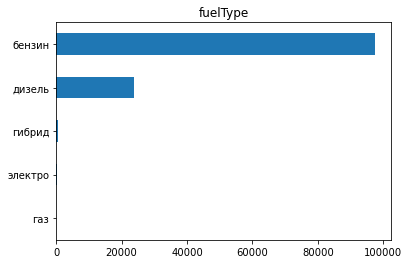

In [47]:
show("fuelType")

Почти все авто на бензине.

Добавим признак в dummy ,т.к. значений не так много.

In [48]:
col_dum.append('fuelType')

### image

In [49]:
show("image") 

https://avatars.mds.yandex.net/get-verba/787013/2a000001609d6c09eb305345ee1ea7e7bd15/wizardv3mr                                                                                                                                  21
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr                                                                                                                                  18
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr                                                                                                                                 17
https://avatars.mds.yandex.net/get-verba/787013/2a000001609ceeb68cbe6dd25fd2629211da/wizardv3mr                                                                                                                                  15
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wiz

Многие ссылки на фото повторяются. Есть карточки автомобилей с шаблонными фото авто. Помечаются как "avatars". Разобьем признак на наличие "avatars"

In [50]:
data_temp['image'].fillna(data_temp['image'].value_counts().index[0],inplace = True)
data_temp['image'] = data_temp['image'].apply(lambda x: 1 if 'avatars' in x else 0)

### mileage

In [51]:
show('mileage') 

0.0         21278
200000.0     1318
150000.0     1144
250000.0     1103
300000.0     1078
            ...  
54020.0         1
109880.0        1
120496.0        1
91653.0         1
179805.0        1
Name: mileage, Length: 22074, dtype: int64


21278 авто с 0 пробегом. Возможно, это новые авто. Или продавец не указал пробег. Оставим пока как есть

In [52]:
show_outliers('mileage')

Колонка mileage
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 1386 (1.13%)




Выбросов не много.(1%)

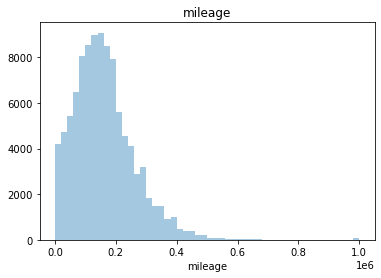

In [53]:
show_distplot('mileage')

 Логарифмируем признак. Визуально распределение улучшилось

In [54]:
log_f('mileage')

В целом признак распределен нормально. .

### modelDate

In [55]:
show('modelDate') 

2017.0    7936
2018.0    7745
2010.0    7228
2006.0    6694
2008.0    6520
          ... 
1965.0       2
1973.0       2
1904.0       2
1950.0       1
1957.0       1
Name: modelDate, Length: 69, dtype: int64


Больше всего авто с датой выпуска за 2017 год

In [56]:
show_outliers('modelDate')

Колонка modelDate
Количество выбросов ниже нижней границы: 2313 (1.89%)
Количество выбросов выше верхней границы: 0 (0.0%)




Выбросов не много.(2+%)

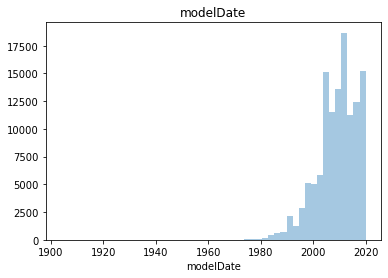

In [57]:
show_distplot('modelDate')

In [58]:
log_f('modelDate')

Логорифмирование признака не приводит к нормальному распределнию. Посмотрим на метрику.

### model_info

In [59]:
show("model_info")

{"code":"octavia","name":"octavia","ru_name":"октавия","morphology":{"gender":"feminine"},"nameplate":{"code":"","name":"","semantic_url":""}}                   1404
{'code': 'polo', 'name': 'polo', 'ru_name': 'поло', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                                 1383
{'code': 'e_klasse', 'name': 'e-класс', 'ru_name': 'е-класс', 'morphology': {}, 'nameplate': {'code': '9264766', 'name': '200', 'semantic_url': '200'}}          1004
{'code': 'outlander', 'name': 'outlander', 'ru_name': 'аутлендер', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                   975
{'code': 'octavia', 'name': 'octavia', 'ru_name': 'октавия', 'morphology': {'gender': 'feminine'}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}     971
                                                                                                                                                                 ... 
{"co

Заполним пропуски и приведем признак к его длине. Посмотрим на метрику.

In [60]:
data_temp['model_info'].fillna('{}',inplace = True)
data_temp['model_info'] = data_temp['model_info'].apply(lambda x: len(x))

### model_name

In [61]:
show("model_name")

octavia         3897
polo            3411
passat          3024
outlander       2886
5er             2695
                ... 
728l               1
123                1
life               1
lancer_cargo       1
528l               1
Name: model_name, Length: 696, dtype: int64


Уникальных моделей много,около 700. Добавим их для LabelEncoder ,чтобы не перегружать количеством признаков датасет.

In [62]:
col_en.append('model_name')

### name

In [63]:
show("name")

1.6 at (110 л.с.)         2386
1.4 amt (150 л.с.)        1213
1.6 mt (102 л.с.)         1178
1.6 mt (110 л.с.)         1148
2.0 cvt (146 л.с.) 4wd    1085
                          ... 
2.5d mt (140 л.с.)           1
sf 1.8 mt (115 л.с.)         1
1.6 at (100 л.с.) 4wd        1
2.4 at (182 л.с.)            1
300 3.0 at (234 л.с.)        1
Name: name, Length: 3667, dtype: int64


Объем и мощность двигателя уже есть в других признаках.Удалим этот признак за ненадобностью.

In [64]:
data_temp.drop('name',axis=1,inplace = True)

### numberOfDoors

5.0    69520
4.0    47255
2.0     3714
3.0     1879
0.0        2
Name: numberOfDoors, dtype: int64


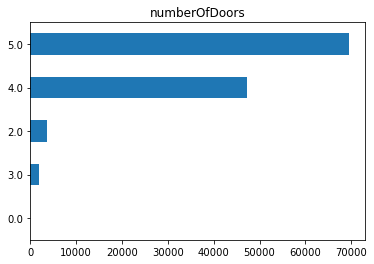

In [65]:
show("numberOfDoors",vc_show = True)

Больше всего пятидверных авто. Но есть авто и без деверей.(ретро). 

Оставим признак как есть

### parsing_unixtime

In [66]:
data_temp['parsing_unixtime'].fillna(0,inplace = True)

In [67]:
show('parsing_unixtime')

0             49100
1606290198        3
1606242186        3
1606286271        3
1606207293        3
              ...  
1603115122        1
1603299230        1
1606244377        1
1603262043        1
1603234148        1
Name: parsing_unixtime, Length: 56585, dtype: int64


In [68]:
def ut_in_date(row):
    value = dt.datetime.fromtimestamp(int(row))
    return value.strftime('%Y-%m-%d %H:%M:%S')

data_temp['parsing_unixtime'] = data_temp['parsing_unixtime'].apply(ut_in_date)

In [69]:
show('parsing_unixtime')

1970-01-01 00:00:00    49100
2020-11-24 17:29:55        3
2020-11-24 18:09:58        3
2020-11-24 06:13:03        3
2020-11-24 17:43:30        3
                       ...  
2020-10-25 07:18:10        1
2020-10-25 00:59:08        1
2020-10-20 20:43:22        1
2020-10-21 07:33:11        1
2020-10-21 07:51:06        1
Name: parsing_unixtime, Length: 56585, dtype: int64


Этот признак удаляем. Его можно было бы использовать для расчёта коэффициента влияния курса доллара на цены авто. (разница курса,когда проходил парсинг и когда прогнозируется цена).
В данном случае, курс доллара на дату парсинга данных и на дату прогнозирования практически не отличается.

In [70]:
data_temp.drop('parsing_unixtime',axis=1,inplace = True)

### priceCurrency

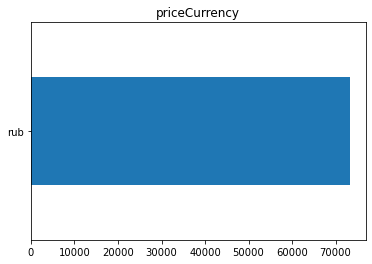

In [71]:
show('priceCurrency')

Валюта продажи только одна - "rub".  
Удаляем признак

In [72]:
data_temp.drop('priceCurrency',axis=1,inplace = True)

### productionDate

In [73]:
show('productionDate') 

2020.0    20698
2012.0     8071
2008.0     7851
2011.0     7605
2013.0     7233
          ...  
1939.0        2
1936.0        2
1904.0        2
1954.0        1
1966.0        1
Name: productionDate, Length: 72, dtype: int64


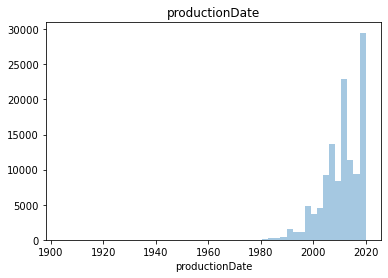

In [74]:
show_distplot('productionDate') 

Распределение не нормальное. Попробуем логарифмировать

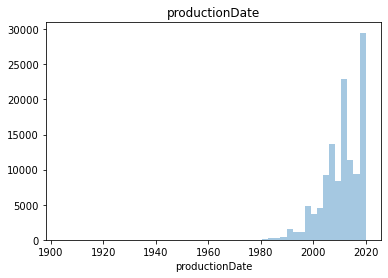

In [75]:
show_distplot('productionDate') 

Распределение не поменялось.Посмотрим на метрику

In [76]:
show_outliers('productionDate')

Колонка productionDate
Количество выбросов ниже нижней границы: 1991 (1.63%)
Количество выбросов выше верхней границы: 0 (0.0%)




Выбросов мало (2%). Оставим как есть

### sell_id

In [77]:
show('sell_id') 

1101662199.0    3
1101644209.0    3
1101531855.0    3
1101294973.0    2
1094575538.0    2
               ..
1101225157.0    1
1101061380      1
1101303271      1
1097458560.0    1
1101129848.0    1
Name: sell_id, Length: 72585, dtype: int64


Заполним пропуски 0 и приведём к числовому типу. Попробуем использовать для обучения модели. 

In [78]:
data_temp['sell_id'].fillna(0,inplace = True)
data_temp['sell_id'] = data_temp['sell_id'].astype('float64')

### super_gen

In [79]:
show('super_gen') 

{'id': '22163516', 'name': 'vi', 'ru_name': '6', 'year_from': 2020, 'price_segment': 'economy'}                                                                                                                                               680
{'id': '21426162', 'name': 'ii (v167)', 'ru_name': '2 (v167)', 'year_from': 2018, 'price_segment': 'premium'}                                                                                                                                 662
{'id': '21397304', 'name': 'iii рестайлинг 3', 'ru_name': '3 рестайлинг 3', 'year_from': 2018, 'price_segment': 'medium'}                                                                                                                     629
{'id': '21733140', 'name': 'ii (c167)', 'ru_name': '2 (c167)', 'year_from': 2019, 'price_segment': 'premium'}                                                                                                                                 567
{'id': '22284156', 'name': 'v (w

Заполним пропуски '{}'.   
Попробуем привести признак к формату ast или json.   
Далее вытащим новые признаки: acceleration(ускорение) ,clearance_min,fuel_rate(расход топлива),clearance_max, gear_type ,price_segment

Приведем признак к его длине.

In [80]:
data_temp['super_gen'].fillna('{}',inplace = True)
data_temp['super_gen'] = data_temp['super_gen'].apply(to_dict)

data_temp['price_segment'] = data_temp['super_gen'].apply(lambda x: get_val(x, 'price_segment', 'absent'))
data_temp['gear_type'] = data_temp['super_gen'].apply(lambda x: get_val(x, 'gear_type', 'absent'))
data_temp['acceleration'] = data_temp['super_gen'].apply(lambda x: get_val(x,'acceleration',0)) 
data_temp['clearance_min'] = data_temp['super_gen'].apply(lambda x: get_val(x,'clearance_min',0)) 
data_temp['clearance_max'] = data_temp['super_gen'].apply(lambda x: get_val(x,'clearance_max',0)) 
data_temp['fuel_rate'] = data_temp['super_gen'].apply(lambda x: get_val(x,'fuel_rate',0))

col_dum.append('price_segment')
col_dum.append('gear_type')

data_temp['super_gen'] = data_temp['super_gen'].apply(lambda x: len(x))

### vehicleConfiguration

In [81]:
show('vehicleConfiguration')

allroad_5_doors variator 2.0     6306
allroad_5_doors automatic 3.0    5906
allroad_5_doors automatic 2.0    5511
sedan automatic 2.0              4585
sedan mechanical 1.6             4038
                                 ... 
wagon_5_doors variator 1.3          1
sedan variator 2.5hyb               1
minivan mechanical 1.6d             1
wagon_5_doors automatic 540i        1
minivan mechanical 5-speed          1
Name: vehicleConfiguration, Length: 1587, dtype: int64


Вся информация есть в других признаках, можно удалить

In [82]:
data_temp.drop(['vehicleConfiguration'], axis=1, inplace=True)

### vehicleTransmission

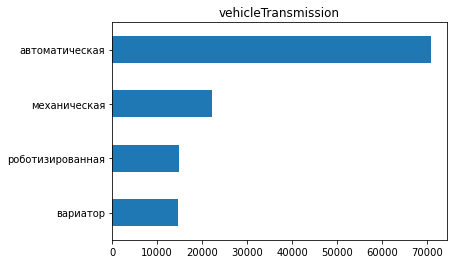

In [83]:
show('vehicleTransmission')

Преобладает автоматическая коробка. Добавим в dummy

In [84]:
col_dum.append('vehicleTransmission')

### vendor

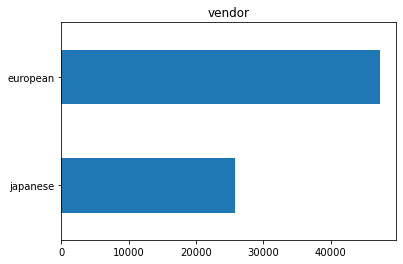

In [85]:
show('vendor')

Заполним пропуски

In [86]:
vendors = {'ford' : 'american','hyundai' : 'korean', 'nissan' : 'japanese', 'peugeot' : 'european', 'porsche' : 'european','renault' : 'european','skoda' : 'european','toyota' : 'japanese','volkswagen' : 'european',
           'volvo' : 'european','great_wall' : 'chinese','land_rover' : 'european','mercedes' : 'european'}
data_temp['vendor'].fillna(data['brand'].map(vendors),inplace = True)

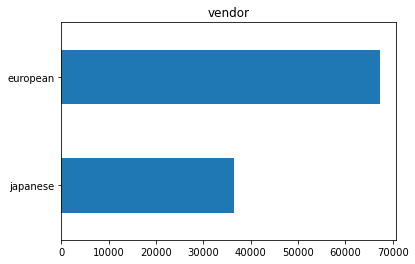

In [87]:
show('vendor')

In [88]:
col_dum.append('vendor')

### Владельцы

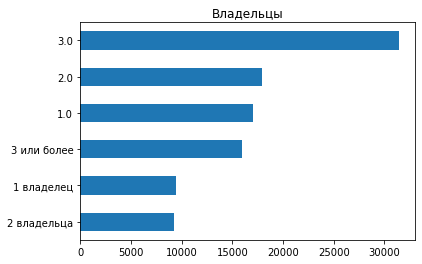

In [89]:
show('Владельцы')

Заполним пропуски 0. Будем считать ,что "3 и более" это 4.

In [90]:
data_temp['Владельцы'].fillna('0',inplace = True)

def change_own(row):
    row = str(row)
    if row.find('или более') > -1:
        return 4
    res = re.match('\d+', row)
    if res is None:
        return row
    else:
        return res[0]
    
data_temp['Владельцы'] = data_temp['Владельцы'].apply(change_own).astype('int64')

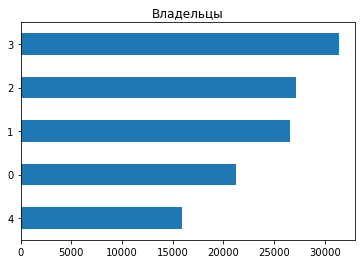

In [91]:
show('Владельцы')

Больше всего у авто было 3 владельца

### Владение

In [92]:
show('Владение')

2 года                         356
1 год и 1 месяц                338
2 года и 1 месяц               336
1 год                          335
1 год и 2 месяца               328
                              ... 
20 лет и 5 месяцев               1
{'year': 1992, 'month': 2}       1
{'year': 1997, 'month': 12}      1
19 лет и 9 месяцев               1
26 лет и 5 месяцев               1
Name: Владение, Length: 582, dtype: int64


В признаке 86271 пропусков. Более 70%. Возможно стоит удалить признак. Посмотрим на метрике.  
Пока попробуем убрать пропуски и определить владение в месяцах

In [93]:
data_temp['Владение'].fillna('0',inplace = True)
def transform(row):
    year_len = len(re.findall('[гл]', row))
    mounth_len = len(re.findall('[мес]', row))
    res = re.findall('\d+', row)
    res_len = len(res)

    new_row = 0

    if year_len > 0:
        new_row += int(res[0]) * 12

    if mounth_len > 0:
        if res_len == 1:
            new_row += int(res[0])
        elif res_len == 2:
            new_row += int(res[1])
    
    if year_len == 0 and mounth_len == 0:
        if res_len == 1:
            new_row += int(res[0])
        elif res_len == 2:
            new_row += int(res[1])
            
    return new_row

data_temp['Владение'] = data_temp['Владение'].apply(transform).astype('int64')

### ПТС

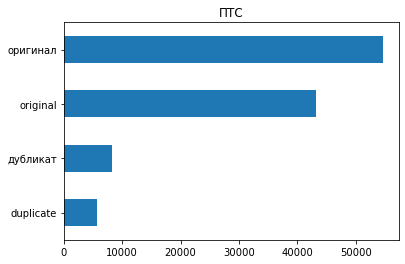

In [94]:
show('ПТС')

Заменим пропуски на 'оригинал'. Склеим оригинал-original и дубликат-duplicate.
Добавим признак в dummy

In [95]:
data_temp['ПТС'].fillna('оригинал',inplace = True)
data_temp['ПТС'] = data_temp['ПТС'].apply(lambda x : 'оригинал' if x in ['original','оригинал'] else 'дубликат')
col_dum.append('ПТС')

### Привод

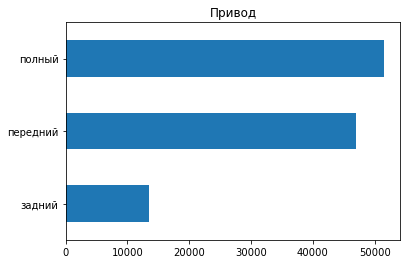

In [96]:
show('Привод')

In [97]:
col_dum.append('Привод')

### Руль

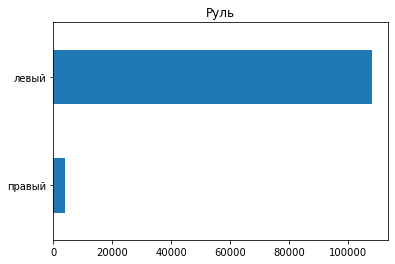

In [98]:
show('Руль')

Авто с правым рулём очень мало. Возможно,стоит удалить признак.Посмотрим метрику.

In [99]:
data_temp['Руль'].fillna('левый',inplace = True)
col_dum.append('Руль')

### Состояние

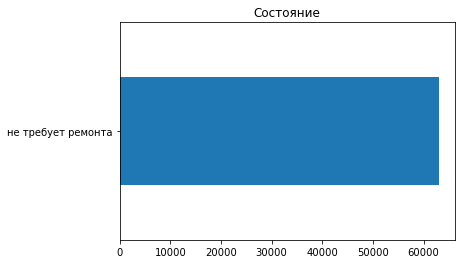

In [100]:
show('Состояние')

Одно значение "не требует ремонта". Удалим признак

In [101]:
data_temp.drop('Состояние',axis=1,inplace = True)

### Таможня

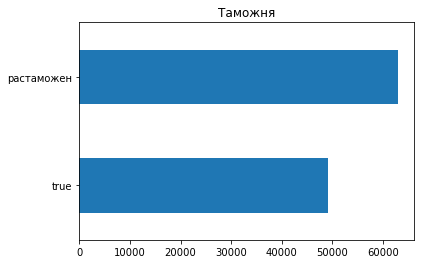

In [102]:
show('Таможня')

Одно значение "растаможен". Удалим признак

In [103]:
data_temp.drop('Таможня',axis=1,inplace = True)

### price

In [104]:
show('price')

0.0          34686
450000.0       884
650000.0       849
550000.0       826
750000.0       766
             ...  
9266700.0        1
3724285.0        1
2841150.0        1
2316900.0        1
9087300.0        1
Name: price, Length: 11029, dtype: int64


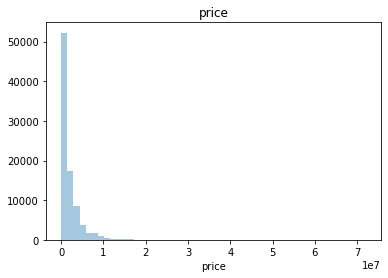

In [105]:
show_distplot('price')

Подавляющее большинство машин стоит до 1 млн. Распределение не нормальное.

In [106]:
show_outliers('price')

Колонка price
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 9486 (7.75%)




Выбросов относительно не много,около 8%.Пока не будем удалять.

Логарифмируем цену

In [107]:
log_f('price')

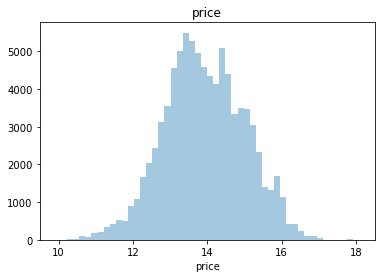

In [108]:
show_distplot('price')

Теперь распределение нормальное.

### Dummy и LableEncoder

In [109]:
#Dummy
for col in col_dum:
    data_temp = pd.get_dummies(data_temp,columns = [col] , prefix = col)

#LabelEncoder
label_encoder = LabelEncoder()
for col in col_en:
    data_temp[col] = label_encoder.fit_transform(data_temp[col])

# 4. General analysis

### Функции

In [110]:
#Корреляция
def show_cor(data_x):
    plt.rcParams['figure.figsize'] = (30,10)
    sns.heatmap(round(data_x.corr(),2),annot=True)
    plt.rcParams['figure.figsize'] = (10,5)
    
#Значимость признаков
def show_important(data_x,cols):
    df_temp = data_x[data_x['sample']==1]
    imp_num = pd.Series(f_classif(df_temp[cols], df_temp['price'])[0], index = cols)
    imp_num.sort_values(inplace = True)
    imp_num.plot(kind = 'barh', title='Значимость переменных для прогнозирования price')
    
#тест Стьюдента
def get_stat_dif(data_x,column):
    cols = data_x.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data_x.loc[data_x.loc[:, column] == comb[0], 'price'], 
                        data_x.loc[data_x.loc[:, column] == comb[1], 'price']).pvalue \
            > 0.05/len(combinations_all): # Учли поправку Бонферони
                print('Не найдены статистически значимые различия для колонки', column)
                break

In [111]:
#Выделим числовые признаки
num_cols = ['mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'price','complectation_dict','engineDisplacement','enginePower','equipment_dict', 'model_info','sell_id','super_gen'
           ,'acceleration','clearance_min' ,'clearance_max','fuel_rate']

**Посмотрим корреляцию для числовых признаков**

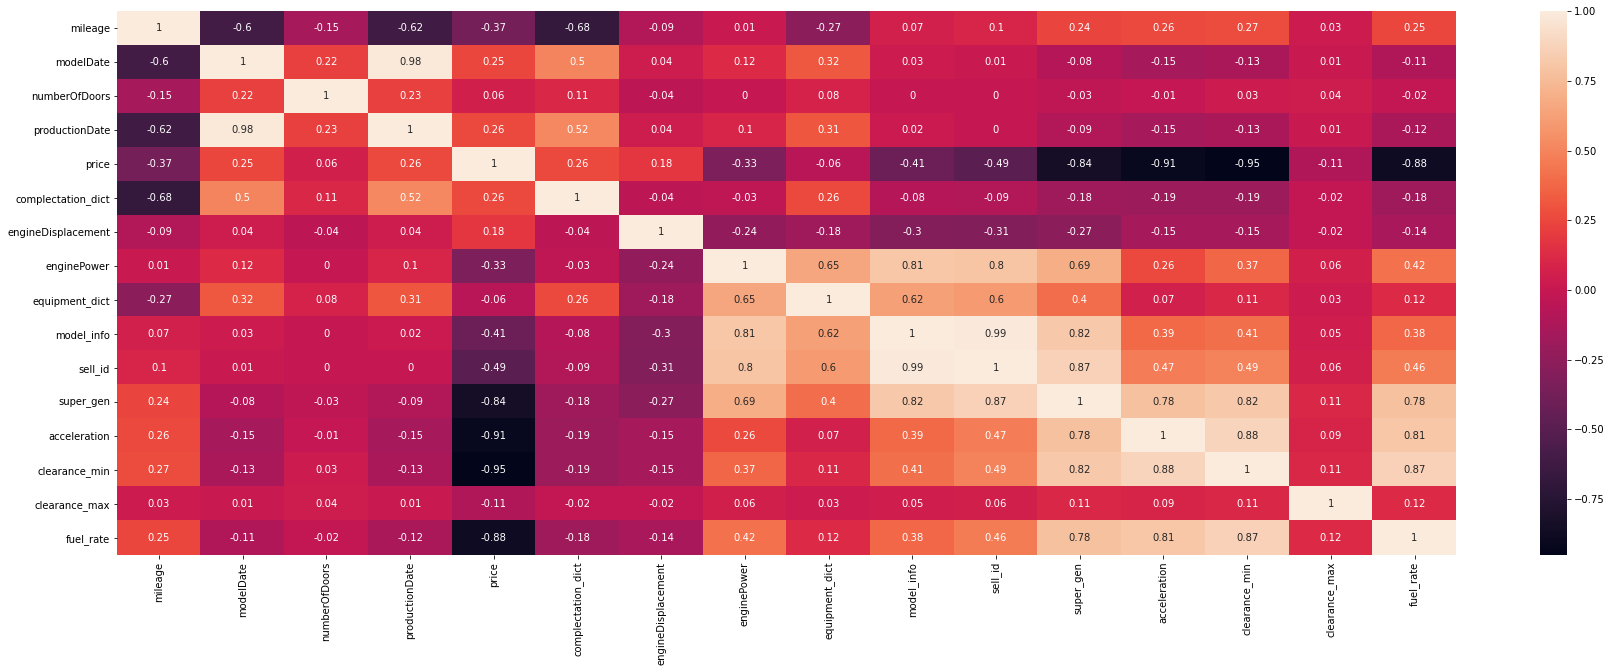

In [112]:
show_cor(data_temp[num_cols])

Высокая корреляция price с признаком super_gen и его субпризнаками.Скорее всего это из-за того,что в этих признаках много пропусков.Это может запутывать модель.Возможно,придется их удалить.

Достаточно высокая корреляция sell_id с price (-0.49). Возможно,на это также влияют пропуски в дополнительно датасете. Посмотрим на метрику.

model_info и sell_id очень сильно коррелируют (0.99). model_info будем удалять,т.к. у него ниже корреляция с price

**Посмотрим значимость переменных для прогнозирования price**

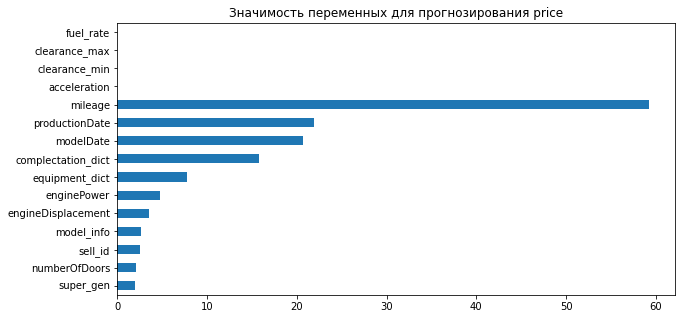

In [113]:
num_cols.remove('price')

show_important(data_temp,num_cols)

Высокую значимость имеют признаки: mileage,productionDate,modelDate

**тест Стьюдента**

Проверим, есть ли статистическая разница в распределении оценок по категориальным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения price по различным параметрам неразличимы.

In [114]:
test_st_col = []

data_temp_sample = data_temp[data_temp['sample'] == 1]

for col in data_temp_sample.columns:
    if data_temp[col].nunique() == 2:
        test_st_col.append(col)

In [115]:
for col in test_st_col:
    get_stat_dif(data_temp,col)

Не найдены статистически значимые различия для колонки salon
Не найдены статистически значимые различия для колонки сarbon_body_kits
Не найдены статистически значимые различия для колонки bodyType_кабриолет
Не найдены статистически значимые различия для колонки bodyType_лимузин
Не найдены статистически значимые различия для колонки bodyType_микровэн
Не найдены статистически значимые различия для колонки bodyType_минивэн
Не найдены статистически значимые различия для колонки bodyType_пикап
Не найдены статистически значимые различия для колонки bodyType_родстер
Не найдены статистически значимые различия для колонки bodyType_тарга
Не найдены статистически значимые различия для колонки bodyType_фастбек
Не найдены статистически значимые различия для колонки brand_volkswagen
Не найдены статистически значимые различия для колонки brand_volvo
Не найдены статистически значимые различия для колонки color_коричневый
Не найдены статистически значимые различия для колонки color_оранжевый
Не найдены

Попробуем удалить статистически незначимые признаки и посмотреть результаты метрики.

# 5. Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в несколько больших функций

In [116]:
#Функции

def to_dict(row):
    try:
        row = ast.literal_eval(row)
        return row 
    except: 
        try:
            row = json.loads(row)
            return row
        except:
            return row

def get_val(row, val_name, val_er):
    try:
        return row[val_name]
    except:
        return val_er

def change_ltr(row):
    row_temp = str(row)
    row_temp = row_temp.replace(' ltr', '')
    try:
        return float(row_temp)
    except:
        return 0
    
def change_n12(row):
    row_temp = str(row)
    row_temp = row_temp.replace(' n12', '')
    try:
        return int(row_temp)
    except:
        return 0
    
def log_f(col,data_x = data_temp):
    data_x[col] = np.log(data_x[col] + 1)
    
def change_own(row):
    row = str(row)
    if row.find('или более') > -1:
        return 4
    res = re.match('\d+', row)
    if res is None:
        return row
    else:
        return res[0]
    
def transform(row):
    year_len = len(re.findall('[гл]', row))
    mounth_len = len(re.findall('[мес]', row))
    res = re.findall('\d+', row)
    res_len = len(res)

    new_row = 0

    if year_len > 0:
        new_row += int(res[0]) * 12

    if mounth_len > 0:
        if res_len == 1:
            new_row += int(res[0])
        elif res_len == 2:
            new_row += int(res[1])
    
    if year_len == 0 and mounth_len == 0:
        if res_len == 1:
            new_row += int(res[0])
        elif res_len == 2:
            new_row += int(res[1])
            
    return new_row

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true)) * 100 #Точность модели по метрике MAPE

In [117]:
#Данные
DATA_DIR = '../input/sf-dst-car-price-prediction/'
df_train = pd.read_csv('../input/myparsingfile/parsing_all_moscow_auto_ru_25_11_20.csv')
df_train_dop = pd.read_csv('../input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv') 
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
#################################

df_train_temp = df_train[df_test.columns]
df_train_temp['price'] = df_train['price']
df_train = df_train_temp

df_train_dop['model_name'] = df_train_dop['model']
df_train_dop['complectation_dict'] = df_train_dop['Комплектация']
df_train_dop.drop(['Комплектация', 'start_date', 'hidden', 'model'],axis=1,inplace= True)

df_train_dop['color'] = df_train_dop['color'].map({'CACECB': 'серебристый', 'FAFBFB':'белый', 'EE1D19':'красный', '97948F':'серый', 
                                     '660099':'пурпурный', '040001':'чёрный','4A2197':'фиолетовый', 
                                     '200204':'коричневый','0000CC':'синий', '007F00':'зелёный', 'C49648':'бежевый',
                                     '22A0F8':'голубой','DEA522':'золотистый','FFD600': 'жёлтый', 'FF8649':'оранжевый',
                                     'FFC0CB':'розовый'})

df_train_dop['vehicleTransmission'] = df_train_dop['vehicleTransmission'].map({'AUTOMATIC': 'автоматическая', 'MECHANICAL':'механическая','VARIATOR': 'вариатор','ROBOT': 'роботизированная'})
df_train_dop['Руль'] = df_train_dop['Руль'].map({'LEFT': 'левый', 'RIGHT':'правый'})

for col in df_train.columns:
    if col not in df_train_dop.columns:
        df_train_dop[col] = None
        
df_train = df_train.append(df_train_dop, sort=False).reset_index(drop=True)

df_train['sample'] = 1
df_test['sample'] = 0
df_test['price'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

data = data[~data.price.isnull()]
data = data[~data.bodyType.isnull()]

for col in data.select_dtypes(include='object').columns:
    data[col][~data[col].isnull()] = data[col][~data[col].isnull()].apply(lambda x: str(x).lower())

brands = list(map(lambda x: str.lower(x),df_test.brand.value_counts().index))
data = data[data['brand'].isin(brands)]

In [149]:
#Подготовка данных для обучения и тестирования
data_temp = data.copy()

col_dum = []
col_en = []

#bodyType
data_temp['bodyType'] = data_temp['bodyType'].apply(lambda x: str(x).split(' ')[0])
data_temp['bodyType'] = data_temp['bodyType'].apply(lambda x: 'купе' if x == 'купе-хардтоп' else x)
data_temp['bodyType'] = data_temp['bodyType'].apply(lambda x: 'седан' if x == 'седан-хардтоп' else x)
col_dum.append('bodyType')

#brand
col_dum.append('brand')

#car_url
data_temp.drop('car_url',axis=1,inplace = True)

#color
col_dum.append('color')

#complectation_dict
data_temp['complectation_dict'].fillna("{'id': '0'}",inplace = True)
data_temp['complectation_dict'] = data_temp['complectation_dict'].apply(lambda x: len(x))

#description
data_temp['description'].fillna('[]',inplace = True)
data_temp['description_word'] = data_temp['description'].apply(lambda x: [i for i in x.split()])

data_temp['salon'] = data_temp['description_word'].apply(lambda x: 
                                             1 if ('рольф' or 'панавто' or 'дилер' or 'кредит' or 'обмен' or 'скид' or 'trade-in' or 'выгода' or 'работаем для вас' or 'автосалон' or 'ликвидация') in x else 0)
data_temp['torg'] = data_temp['description_word'].apply(lambda x: 
                                            1 if ('торг') in x else 0)
data_temp['leather']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('темный' and 'салон') in x else 0)
data_temp['carter']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('защита' and 'картера') in x else 0)
data_temp['ABS']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('антиблокировочная' and 'система') in x else 0)
data_temp['airbags']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('подушки' and 'безопасности') in x else 0)
data_temp['immob']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('иммобилайзер') in x else 0)
data_temp['central_locking']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('центральный' and 'замок') in x else 0)
data_temp['on_board_computer']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('бортовой' and 'компьютер') in x else 0)
data_temp['cruise_control']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('круиз-контроль') in x else 0)
data_temp['climat_control']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('климат-контроль') in x else 0)
data_temp['multi_rudder']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('мультифункциональный' and 'руль') in x else 0)
data_temp['power_steering']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('гидроусилитель' or 'гидро' or 'усилитель' and 'руля') in x else 0)
data_temp['light_and_rain_sensors']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('датчики' and 'света' and 'дождя') in x else 0)
data_temp['сarbon_body_kits']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('карбоновые' and 'обвесы') in x else 0)
data_temp['rear_diffuser_rkp']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('задний' and 'диффузор') in x else 0)
data_temp['door_closers']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('доводчики' and 'дверей') in x else 0)
data_temp['rear_view_camera']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('камера' or 'видеокамера' and 'заднего' and 'вида') in x else 0)
data_temp['amg']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('amg') in x else 0)
data_temp['bi_xenon_headlights']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('биксеноновые' and 'фары') in x else 0)
data_temp['alloy_wheels']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('легкосплавные' or 'колесные' or 'диски') in x else 0)
data_temp['parking_sensors']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('парктроник' or 'парктронник') in x else 0)
data_temp['dents']= data_temp['description_word'].apply(lambda x: 
                                            1 if ('вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина') in x else 0)
data_temp['roof_with_panoramic_view']= data_temp['description_word'].apply(lambda x: 1 if ('панорамная' and 'крыша') in x else 0)
data_temp.drop(['description','description_word'],axis = 1, inplace = True)

#engineDisplacement
data_temp['engineDisplacement'] = data_temp['engineDisplacement'].apply(change_ltr).astype('float64')

#enginePower
data_temp['enginePower'] = data_temp['enginePower'].apply(change_n12).astype('int64')

#equipment_dict
data_temp['equipment_dict'].fillna("{}",inplace = True)
data_temp['equipment_dict'] = data_temp['equipment_dict'].apply(lambda x: len(x))

#fuelType
col_dum.append('fuelType')

#image
data_temp['image'].fillna(data_temp['image'].value_counts().index[0],inplace = True)
data_temp['image'] = data_temp['image'].apply(lambda x: 1 if 'avatars' in x else 0)

#mileage
#log_f('mileage')

#modelDate
#log_f('modelDate')

#model_info
data_temp['model_info'].fillna('{}',inplace = True)
data_temp['model_info'] = data_temp['model_info'].apply(lambda x: len(x))

#model_name
col_en.append('model_name')

#name
data_temp.drop('name',axis=1,inplace = True)

#numberOfDoors

#parsing_unixtime
data_temp.drop('parsing_unixtime',axis=1,inplace = True)

#priceCurrency
data_temp.drop('priceCurrency',axis=1,inplace = True)

#productionDate

#sell_id
data_temp['sell_id'].fillna(0,inplace = True)
data_temp['sell_id'] = data_temp['sell_id'].astype('float64')

#super_gen  Отсутствие данных ,корреляция с price ,метрика хуже - закомменитровал
# data_temp['super_gen'].fillna('{}',inplace = True)
# data_temp['super_gen'] = data_temp['super_gen'].apply(to_dict)
# data_temp['price_segment'] = data_temp['super_gen'].apply(lambda x: get_val(x, 'price_segment', 'absent'))
# data_temp['gear_type'] = data_temp['super_gen'].apply(lambda x: get_val(x, 'gear_type', 'absent'))
# data_temp['acceleration'] = data_temp['super_gen'].apply(lambda x: get_val(x,'acceleration',0)) 
# data_temp['clearance_min'] = data_temp['super_gen'].apply(lambda x: get_val(x,'clearance_min',0)) 
# data_temp['clearance_max'] = data_temp['super_gen'].apply(lambda x: get_val(x,'clearance_max',0)) 
# data_temp['fuel_rate'] = data_temp['super_gen'].apply(lambda x: get_val(x,'fuel_rate',0))
# col_dum.append('price_segment')
# col_dum.append('gear_type')
#data_temp['super_gen'] = data_temp['super_gen'].apply(lambda x: len(x))
data_temp.drop('super_gen', axis=1, inplace=True)

#vehicleConfiguration
data_temp.drop(['vehicleConfiguration'], axis=1, inplace=True)

#vehicleTransmission
col_dum.append('vehicleTransmission')

#vendor
vendors = {'ford' : 'american','hyundai' : 'korean', 'nissan' : 'japanese', 'peugeot' : 'european', 'porsche' : 'european','renault' : 'european','skoda' : 'european','toyota' : 'japanese','volkswagen' : 'european',
           'volvo' : 'european','great_wall' : 'chinese','land_rover' : 'european','mercedes' : 'european'}
data_temp['vendor'].fillna(data['brand'].map(vendors),inplace = True)
data_temp['vendor'].fillna('european',inplace = True)
col_dum.append('vendor')

#Владельцы
data_temp['Владельцы'].fillna('0',inplace = True)
data_temp['Владельцы'] = data_temp['Владельцы'].apply(change_own).astype('int64')

#Владение
# data_temp['Владение'].fillna('0',inplace = True)
# data_temp['Владение'] = data_temp['Владение'].apply(transform).astype('int64')
data_temp.drop('Владение',axis=1,inplace = True)

#ПТС
data_temp['ПТС'].fillna('оригинал',inplace = True)
data_temp['ПТС'] = data_temp['ПТС'].apply(lambda x : 'оригинал' if x in ['original','оригинал'] else 'дубликат')
col_dum.append('ПТС')

#Привод
data_temp['Привод'].fillna('передний',inplace = True)
col_dum.append('Привод')

#Руль
data_temp['Руль'].fillna('левый',inplace = True)
col_dum.append('Руль')

#Состояние
data_temp.drop('Состояние',axis=1,inplace = True)

#Таможня
data_temp.drop('Таможня',axis=1,inplace = True)

#sample

#price
data_temp['price'] = np.log(data_temp['price'] + 1)

#dummy
for col in col_dum:
    data_temp = pd.get_dummies(data_temp,columns = [col] , prefix = col)

#LabelEncoder
label_encoder = LabelEncoder()
for col in col_en:
    data_temp[col] = label_encoder.fit_transform(data_temp[col])
    
#Удалить по результатам общего анализа (Ухудшает метрику)
#del_col = ['salon','сarbon_body_kits','bodyType_кабриолет','bodyType_лимузин','bodyType_микровэн','bodyType_минивэн','bodyType_пикап','bodyType_родстер','bodyType_тарга','bodyType_фастбек','brand_volkswagen','brand_volvo',
# 'color_коричневый','color_оранжевый','color_розовый','color_серый','fuelType_газ']

#data_temp.drop(del_col,axis = 1,inplace = True)

# 6. Model

In [150]:
train_data = data_temp.query('sample == 1').drop(['sample'], axis=1)

#train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #Очистить non-ASCII для LGBMRegressor

X = train_data.drop(['price'], axis=1)
y = train_data['price'].values

In [151]:
models = []

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.8s finished


MAPE: 10.90895
CPU times: user 6min 49s, sys: 1.13 s, total: 6min 50s
Wall time: 1min 45s


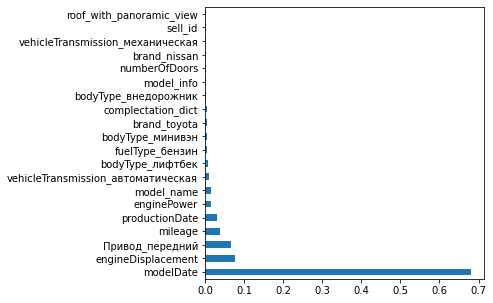

In [152]:
%%time 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

#RandomForestRegressor # best MAPE ноут/лидерборд : 10.90895 / 11.96442
model = RandomForestRegressor(n_estimators=300, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test = np.round(np.exp(y_test))
y_pred = np.round(np.exp(y_pred))

print(f'MAPE: {np.round(mape(y_test,y_pred),5)}') 

# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

models.append(model)

Если дать CatBoostRegressor самому сделать one-hot-encoding,выходит результат хуже

In [153]:
# %%time 

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# #индексы категориальных колонок
# string_ind = []
# for col in col_dum + col_en:
#     string_ind.append(data_temp.columns.get_loc(col))

# #CatBoostRegressor # best MAPE ноут/лидерборд : 12.32113 /  14.35948
# model = CatBoostRegressor(random_seed = RANDOM_SEED,eval_metric='MAPE',logging_level='Silent')

# cat_features = string_ind
# model.fit(X_train, y_train,cat_features = cat_features)

# y_pred = model.predict(X_test)

# y_test = np.round(np.exp(y_test))
# y_pred = np.round(np.exp(y_pred))

# print(f'MAPE: {np.round(mape(y_test,y_pred),5)}') 

# # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
# plt.rcParams['figure.figsize'] = (5,5)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='barh')

MAPE: 10.70074
CPU times: user 2min 40s, sys: 15.1 s, total: 2min 56s
Wall time: 56.6 s


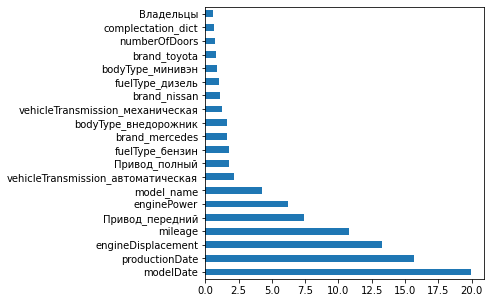

In [154]:
%%time 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

#CatBoostRegressor # best MAPE ноут/лидерборд : 10.71019 /  12.34601
model = CatBoostRegressor(iterations = 5000,learning_rate = 0.1,random_seed = RANDOM_SEED,eval_metric='MAPE',logging_level='Silent')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test = np.round(np.exp(y_test))
y_pred = np.round(np.exp(y_pred))

print(f'MAPE: {np.round(mape(y_test,y_pred),5)}') 

# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

models.append(model)

LGBMRegressor не работает,т.к. в колонках есть non-ASCII символы

In [155]:
# gbm = lgb.LGBMRegressor(n_estimators = 300, random_state = RANDOM_SEED)
# gbm.fit(X_train, y_train,
#         eval_set=[(X_test, y_test)],
#         eval_metric=['mape'],
#         early_stopping_rounds=3
#        )
# y_pred = gbm.predict(X_test)

# print(f'MAPE: {np.round(mape(y_test,y_pred),5)}') 

XGBRegressor не использую,т.к. результаты на лидерборде немного хуже из-за него при усреднении

In [156]:
# %%time

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# def xgb_mape(preds, dtrain):
#     labels = dtrain.get_label()
#     return('mape', np.mean(np.abs((labels - preds) / (labels + 1))) * 100)

# #XGBRegressor best MAPE ноут/лидерборд: 8.84756 /13.175
# xgb = XGBRegressor(n_estimators = 300, n_jobs = -1, random_state = RANDOM_SEED)
# xgb.fit(
#         X, y,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         eval_metric=xgb_mape,
#         early_stopping_rounds=10
#        )

# y_pred = xgb.predict(X_test)
# y_test = np.round(np.exp(y_test))
# y_pred = np.round(np.exp(y_pred))

# print(f'MAPE: {np.round(mape(y_test,y_pred),5)}') 

# models.append(xgb)

In [157]:
%%time
#Усредним ответы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

y_pred = np.zeros(len(X_test))

for model in models:
    y_pred += model.predict(X_test)

y_pred = y_pred/len(models)

y_test = np.round(np.exp(y_test))
y_pred = np.round(np.exp(y_pred))

print(f'MAPE: {np.round(mape(y_test,y_pred),5)}') 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s


MAPE: 10.27939
CPU times: user 3.08 s, sys: 55.3 ms, total: 3.13 s
Wall time: 907 ms


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.8s finished


In [158]:
# %%time

# #средняя оценка по кросс-валидации
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(xgb, X_train, y_train,n_jobs = -1, cv=5)
# print("Mean cross-validation score: %.2f" % scores.mean())

## Подбор параметров 
Не дал лучших результатов метрики на лидерборде

In [159]:
# train_data = data_temp.query('sample == 1').drop(['sample'], axis=1)

# X = train_data.drop(['price'], axis=1)
# y = train_data['price'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# n_estimators = [x for x in range(100, 550, 50)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num=10)]
# max_depth.append(None)
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'bootstrap': bootstrap}

# rf = RandomForestRegressor(random_state=RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
#                                random_state=RANDOM_SEED, n_jobs=-1)
# rf_random.fit(X_train, y_train)

# print(rf_random.best_params_)

{'bootstrap': True,
'max_depth': 98,
'max_features': 'auto',
'n_estimators': 500}

## **Stacking** 
Результат метрики в ноутбуке выше,но на лидерборде ниже

In [160]:
# def compute_meta_feature(clf, X_train, X_test, y_train, cv):

#     X_meta_train = np.zeros_like(y_train, dtype=np.float32)
#     for train_fold_index, predict_fold_index in cv.split(X_train):
#         X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
#         y_fold_train = y_train[train_fold_index]

#         folded_clf = clone(clf)
#         folded_clf.fit(X_fold_train, y_fold_train)
#         X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)

#     meta_clf = clone(clf)
#     meta_clf.fit(X_train, y_train)

#     X_meta_test = meta_clf.predict(X_test)

#     return X_meta_train, X_meta_test


# def generate_metafeatures(classifiers, X_train, X_test, y_train, cv):

#     features = [
#         compute_meta_feature(clf, X_train, X_test, y_train, cv)
#         for clf in tqdm(classifiers)
#     ]

#     stacked_features_train = np.vstack([
#         features_train for features_train, features_test in features
#     ]).T

#     stacked_features_test = np.vstack([
#         features_test for features_train, features_test in features
#     ]).T

#     return stacked_features_train, stacked_features_test

# models = [
#     RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=RANDOM_SEED),
#     BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED),
#     CatBoostRegressor(iterations = 5000,learning_rate = 0.1,random_seed = RANDOM_SEED,eval_metric='MAPE',logging_level='Silent'),
#     GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED)
# ]

# train_data = data_temp.query('sample == 1').drop(['sample'], axis=1)

# X = train_data.drop(['price'], axis=1)
# y = train_data['price'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_SEED)

# cv = KFold(n_splits=3, shuffle=True)

# stacked_features_train, stacked_features_test = generate_metafeatures(models, X_train.values, X_test.values, y_train, cv)

# clf = LinearRegression(n_jobs = -1)
# clf.fit(stacked_features_train, y_train)
# y_pred = clf.predict(stacked_features_test)

# y_test = np.round(np.exp(y_test))
# y_pred = np.round(np.exp(y_pred))

# print(f'MAPE: {np.round(mape(y_test, y_pred), 5)}')

# 7. Submission

In [161]:
#усредненное
X_sub = data_temp.query('sample == 0').drop(['sample','price'], axis=1)
y_pred = np.zeros(len(X_sub))

for model in models:
    y_pred += model.predict(X_sub)
    
y_pred = y_pred / len(models)
y_pred = np.round(np.exp(y_pred))
    
sample_submission['price'] = y_pred
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.1s finished


,sell_id,price
0,1100575026,676104.0
1,1100549428,1009625.0
2,1100658222,866819.0
3,1100937408,773140.0
4,1101037972,733691.0
5,1100912634,789766.0
6,1101228730,628950.0
7,1100165896,411850.0
8,1100768262,1924020.0
9,1101218501,917976.0


In [130]:
# X_sub = data_temp.query('sample == 0').drop(['sample','price'], axis=1)

# predict_submission = model.predict(X_sub)

# predict_submission = np.round(np.exp(predict_submission))

# sample_submission['price'] = predict_submission
# sample_submission.to_csv(f'submission.csv', index=False)
# sample_submission.head(10)